# 2) Exploratory Data Analysis

In [1]:
#@title Code Library
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import pdb
import random
from tqdm import tqdm, tqdm_notebook

def add_dataRow(dataset, dataRow, columns):
  temp_df = pd.DataFrame([dataRow], columns= columns)
  dataset = dataset.append(temp_df, ignore_index= True)
  return dataset

def data_overview(dataset, target_variable):
  df = dataset.drop(columns = target_variable)

  columns = ["Observation", "Value"]
  result_dataset = pd.DataFrame(columns=columns)

  result_dataset = add_dataRow(result_dataset, ["Number of rows", df.shape[0]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of columns", df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of numeric variables", df._get_numeric_data().shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of categorical variables", df.select_dtypes(include="category").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of text & id variables", df.select_dtypes(include=object).shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of logical variables", df.select_dtypes(include="bool").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of date variables", df.select_dtypes(include="datetime64").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of uniform variables", df.loc[:,df.apply(pd.Series.nunique) == 1].shape[1]], columns)

  null_df = pd.DataFrame(df.isnull().sum()/df.shape[0],columns=["null_sum"])
  result_dataset = add_dataRow(result_dataset, ["% of complete case rows",(null_df[null_df["null_sum"] == 0].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (<50%)",(null_df[null_df["null_sum"] <= 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>50%)",(null_df[null_df["null_sum"] > 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>90%)",(null_df[null_df["null_sum"] > 0.9].shape[0]*100)/df.shape[1]], columns)



  return result_dataset

def target_variable_info(dataset, target_variable):
  classes = np.unique(dataset[target_variable])
  
  columns=["Observation","Value"]
  df = pd.DataFrame(columns= columns)

  df = add_dataRow(df, ["Number of classes", len(classes)], columns)
  for xclass in classes:
    value = dataset[dataset[target_variable] == xclass].shape[0]
    df = add_dataRow(df, ["Number of data points in class " + str(xclass), value], columns)

  return df

def df_without_outliers(dataset, col, count=False):
  # pdb.set_trace()
  firstQuantile = dataset[col].quantile(0.25)
  thirdQuantile = dataset[col].quantile(0.75)
  IQR = thirdQuantile - firstQuantile
  leftFence = firstQuantile - (1.5*IQR)
  rightFence = thirdQuantile + (1.5*IQR)
  if count:
    dataset = dataset[(dataset[col] < leftFence) | (dataset[col] > rightFence)]
  else:
    dataset = dataset[(dataset[col] >= leftFence) & (dataset[col] <= rightFence)]

  return dataset

def numerical_overview(dataset, target_variable):
  df = dataset.drop(columns= target_variable)._get_numeric_data()

  columns = ["Variable name", "+ve value count", "-ve value count", "Zero count", \
             "Unique count", "+ve infinity count", "-ve infinity count", \
             "missing %", "Count of outliers"]

  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[df[col] > 0].shape[0])
    dataRow.append(df[df[col] < 0].shape[0])
    dataRow.append(df[df[col] == 0].shape[0])
    dataRow.append(len(df[col].unique()))
    dataRow.append(df[df[col] == np.inf].shape[0])
    dataRow.append(df[df[col] == -np.inf].shape[0])
    dataRow.append((df[col].isnull().sum()*100)/df.shape[0])
    dataRow.append(df_without_outliers(df, col, True).shape[0])

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def categorical_feature_overview(dataset, target_variable):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable).select_dtypes(include="category")

  columns = ["Variable name", "Unique categories", "% missing values"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(len(pd.unique(df[col])))
    dataRow.append(round(((df[col].isnull().sum())*100)/df.shape[0], 3))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def min_text_count(df, col):
  min = -1
  for val in df[col]:
    if not pd.isna(val):
      newMin = len(val.split(" "))
      if min == -1 or min > len(val.split(" ")):
        min = newMin
  
  return min

def max_text_count(df, col):
  max = -1
  for val in df[col]:
    if not pd.isna(val):
      newMax = len(val.split(" "))
      if max == -1 or max < len(val.split(" ")):
        max = newMax
  
  return max

def text_feature_overview(dataset, target_variable):
  df = dataset.drop(columns=target_variable).select_dtypes(include=object)

  columns = ["Variable name", "No. of unique words", "Min no. of words in a document", "Max no. of words in a document", "% missing data"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []
    if "id" not in col.lower():
      df[col] = df[col].apply(lambda x : re.sub('\W+',' ', str(x).lower()) if not pd.isna(x) else x)
      # print(df[col])
      dataRow.append(col)
      dataRow.append(len(pd.unique(df[col])))
      dataRow.append(min_text_count(df, col))
      dataRow.append(max_text_count(df, col))
      # print((df[col].isnull()))
      dataRow.append(round((df[col].isnull().sum()*100)/df.shape[0], 2))

      result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def stat_overview(dataset, target_variable):
  df = dataset.drop(columns=target_variable)._get_numeric_data()

  columns = ["Variable name", "Count", "Mean", "Standard deviation", "Variance", \
             "Min", "25th Percentile", "50th Percentile", "75th Percentile", \
             "Max", "10th Percentile", "90th Percentile", "95th Percentile"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[col].count())
    dataRow.append(df[col].mean())
    dataRow.append(df[col].std())
    dataRow.append(df[col].var())
    dataRow.append(df[col].min())
    dataRow.append(df[col].quantile(0.25))
    dataRow.append(df[col].quantile(0.50))
    dataRow.append(df[col].quantile(0.75))
    dataRow.append(df[col].max())
    dataRow.append(df[col].quantile(0.10))
    dataRow.append(df[col].quantile(0.90))
    dataRow.append(df[col].quantile(0.95))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def density_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  fig, axes = plt.subplots(df.shape[1],figsize=(5,df.shape[1]*5))
  for index, col in enumerate(df.columns):
    if "id" not in col:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.distplot(plot_df[col], ax=a)

def box_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  figs, axes = plt.subplots(df.shape[1], figsize = (5, df.shape[1]*5))

  for index, col in enumerate(df.columns):
    if "id" not in col and col != target_variable:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.boxplot(y=plot_df[col], ax=a,orient="v")

def stacked_bar_plot(dataset ,target_variable, top=10):
  # pdb.set_trace()
  data = dataset.select_dtypes(include="category")
  for x_variable in data.columns:

    df = pd.DataFrame(dataset.groupby(x_variable)[target_variable].agg(lambda x : x.eq(1).sum())).reset_index()
    print(df.columns)
    df["total"] = dataset.groupby(x_variable)[target_variable].agg(total="count").reset_index()["total"]
    df.sort_values(by=['total'],inplace=True, ascending=False)

    if df.shape[0] > top:
      df = df[:top]

    ind = np.arange(df.shape[0])

    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, df["total"].values)
    p2 = plt.bar(ind, df[target_variable].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(df[x_variable].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

## 2.1 Loading Data

In [2]:
priceData_19 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2019.csv")
priceData_20 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2020.csv")
priceData_21 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2021.csv")
priceData_22 = pd.read_csv(r"..\Datasets\Day-Ahead Price_Hourly\Prices_2022.csv")

raw_priceData = pd.concat([priceData_19,priceData_20,priceData_21,priceData_22])
print(raw_priceData.shape)
raw_priceData.head()


(35064, 2)


,MTU (UTC),Day-ahead Price [EUR/MWh]
0,01.01.2019 00:00 - 01.01.2019 01:00,70.28
1,01.01.2019 01:00 - 01.01.2019 02:00,65.18
2,01.01.2019 02:00 - 01.01.2019 03:00,60.91
3,01.01.2019 03:00 - 01.01.2019 04:00,65.16
4,01.01.2019 04:00 - 01.01.2019 05:00,65.16


In [3]:
priceData=raw_priceData.copy()
priceData['MTU (UTC)'] = priceData['MTU (UTC)'].str.split('-').str[0]
priceData['MTU (UTC)'] = pd.to_datetime(priceData['MTU (UTC)'])
priceData.head()



,MTU (UTC),Day-ahead Price [EUR/MWh]
0,2019-01-01 00:00:00,70.28
1,2019-01-01 01:00:00,65.18
2,2019-01-01 02:00:00,60.91
3,2019-01-01 03:00:00,65.16
4,2019-01-01 04:00:00,65.16


In [4]:
priceData.rename(columns={"MTU (UTC)": "TimeStamp", "Day-ahead Price [EUR/MWh]": "ElectricityPrice"},inplace=True)

In [5]:
energyData_19 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2019.csv")
energyData_20 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2020.csv")
energyData_21 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2021.csv")
energyData_22 = pd.read_csv(r"..\Datasets\Energy Charts diff sources\energy_2022.csv")

raw_energyData = pd.concat([energyData_19,energyData_20,energyData_21,energyData_22])
print(raw_energyData.shape)
raw_energyData.head()

(68172, 10)


,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load
0,01-01-2019 0.00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2
1,01-01-2019 0.30,128.6,0.0,34.6,219.2,1019.8,0.0,0.0,581.6,2955.4
2,01-01-2019 1.00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1
3,01-01-2019 1.30,124.0,0.0,35.5,226.4,691.9,0.0,0.0,610.0,2769.2
4,01-01-2019 2.00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9


In [6]:
energyData=raw_energyData.copy()
energyData['Date (GMT+1)'] = pd.to_datetime(energyData['Date (GMT+1)'],format='%d-%m-%Y %H.%M')
energyData.head()

,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load
0,2019-01-01 00:00:00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2
1,2019-01-01 00:30:00,128.6,0.0,34.6,219.2,1019.8,0.0,0.0,581.6,2955.4
2,2019-01-01 01:00:00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1
3,2019-01-01 01:30:00,124.0,0.0,35.5,226.4,691.9,0.0,0.0,610.0,2769.2
4,2019-01-01 02:00:00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9


In [7]:
energyData["drop_value"] = energyData['Date (GMT+1)'].dt.minute.isin([30])
energyData.head()

,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load,drop_value
0,2019-01-01 00:00:00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2,False
1,2019-01-01 00:30:00,128.6,0.0,34.6,219.2,1019.8,0.0,0.0,581.6,2955.4,True
2,2019-01-01 01:00:00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1,False
3,2019-01-01 01:30:00,124.0,0.0,35.5,226.4,691.9,0.0,0.0,610.0,2769.2,True
4,2019-01-01 02:00:00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9,False


In [8]:
energyData = energyData[energyData['drop_value'] == False]
energyData.head()

,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load,drop_value
0,2019-01-01 00:00:00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2,False
2,2019-01-01 01:00:00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1,False
4,2019-01-01 02:00:00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9,False
6,2019-01-01 03:00:00,124.1,0.0,35.6,190.7,451.6,0.0,0.0,490.8,2479.8,False
8,2019-01-01 04:00:00,124.4,0.0,36.0,197.1,458.5,0.0,0.0,397.3,2401.8,False


In [9]:
energyData.reset_index()

,index,Date (GMT+1),Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load,drop_value
0,0,2019-01-01 00:00:00,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2,False
1,2,2019-01-01 01:00:00,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1,False
2,4,2019-01-01 02:00:00,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9,False
3,6,2019-01-01 03:00:00,124.1,0.0,35.6,190.7,451.6,0.0,0.0,490.8,2479.8,False
4,8,2019-01-01 04:00:00,124.4,0.0,36.0,197.1,458.5,0.0,0.0,397.3,2401.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...
34081,15554,2022-11-21 01:00:00,105.2,196.0,0.0,41.5,437.0,0.0,0.0,2662.1,NaN,False
34082,15556,2022-11-21 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
34083,15558,2022-11-21 03:00:00,104.5,199.6,0.0,41.5,418.5,0.0,0.0,2597.9,NaN,False
34084,15560,2022-11-21 04:00:00,104.5,198.7,0.0,41.5,454.0,0.0,0.0,2309.2,NaN,False


In [10]:
energyData.rename(columns={"Date (GMT+1)": "TimeStamp"},inplace=True)

In [11]:
energyData=energyData.drop(columns=['drop_value'])

In [12]:
demandData_19 = pd.read_excel(r"..\Datasets\Demand_Generation\Demand_2019.xlsx")
demandData_20_21 = pd.read_excel(r"..\Datasets\Demand_Generation\Demand_2020_2021.xlsx")
demandData_22 = pd.read_excel(r"..\Datasets\Demand_Generation\Demand_2022.xlsx")
raw_demandData = pd.concat([demandData_19,demandData_20_21,demandData_22])
print(raw_demandData.shape)
raw_demandData.head()


(140256, 15)


,DateTime,GMT Offset,NI Generation,NI Demand,NI Wind Availability,NI Wind Generation,NI Solar Availability,NI Solar Generation,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Unnamed: 13,NI: Northern Ireland\nIE: Ireland
0,2019-01-01 00:00:00,0,653.097,684.529,528.603,331.564,0.292,0.0,2444.54,3005.92,599.98,599.15,0.4215,NaN,NaN
1,2019-01-01 00:15:00,0,647.814,672.875,531.042,330.755,0.292,0.0,2468.85,2975.35,582.54,582.31,0.4061,NaN,NaN
2,2019-01-01 00:30:00,0,617.944,657.320,534.835,309.784,0.292,0.0,2446.11,2937.55,596.78,596.48,0.4087,NaN,NaN
3,2019-01-01 00:45:00,0,589.480,640.818,519.645,282.319,0.287,0.0,2364.82,2903.44,625.33,625.77,0.4292,NaN,NaN
4,2019-01-01 01:00:00,0,591.209,652.555,494.949,275.899,0.292,0.0,2326.80,2865.43,628.30,626.40,0.4324,NaN,NaN


In [13]:
demandData=raw_demandData.copy()
demandData["drop_value"] = demandData['DateTime'].dt.minute.isin([15,30,45])

In [14]:
demandData = demandData[demandData['drop_value'] == False]
demandData.head()

,DateTime,GMT Offset,NI Generation,NI Demand,NI Wind Availability,NI Wind Generation,NI Solar Availability,NI Solar Generation,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Unnamed: 13,NI: Northern Ireland\nIE: Ireland,drop_value
0,2019-01-01 00:00:00,0,653.097,684.529,528.603,331.564,0.292,0.0,2444.54,3005.92,599.98,599.15,0.4215,NaN,NaN,False
4,2019-01-01 01:00:00,0,591.209,652.555,494.949,275.899,0.292,0.0,2326.80,2865.43,628.30,626.40,0.4324,NaN,NaN,False
8,2019-01-01 02:00:00,0,497.152,613.700,416.473,193.523,0.292,0.0,1993.39,2613.60,517.65,513.24,0.4485,NaN,NaN,False
12,2019-01-01 03:00:00,0,452.127,581.355,355.045,147.197,0.292,0.0,1752.69,2470.13,492.99,489.53,0.4832,NaN,NaN,False
16,2019-01-01 04:00:00,0,424.964,566.805,282.425,109.138,0.292,0.0,1717.17,2384.35,424.52,378.44,0.4460,NaN,NaN,False


In [15]:
demandData.rename(columns={"DateTime": "TimeStamp"},inplace=True)

In [16]:
demandData=demandData.drop(columns=['GMT Offset', 'NI Generation','NI Demand','NI Wind Availability','NI Wind Generation','NI Solar Availability','NI Solar Generation','Unnamed: 13',
                 'NI: Northern Ireland\nIE: Ireland','drop_value'])


In [17]:
demandData.reset_index()

,index,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP
0,0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215
1,4,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324
2,8,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485
3,12,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832
4,16,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460
...,...,...,...,...,...,...,...
35059,35020,2022-12-31 19:00:00,3706.56,4115.32,321.07,306.51,0.2145
35060,35024,2022-12-31 20:00:00,3603.50,3865.44,520.18,503.15,0.2394
35061,35028,2022-12-31 21:00:00,3199.47,3650.31,527.51,510.51,0.2904
35062,35032,2022-12-31 22:00:00,2807.23,3450.39,515.50,500.27,0.3378


In [18]:
weatherData = pd.read_csv(r"..\Datasets\Weather_Dublin.csv")
weatherData.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
0,01-01-2019 0.00,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250,2,11,0.0,30000,999,3
1,01-01-2019 1.00,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250,2,11,0.0,30000,999,3
2,01-01-2019 2.00,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240,2,11,0.0,30000,999,3
3,01-01-2019 3.00,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250,2,11,0.0,30000,30,6
4,01-01-2019 4.00,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250,2,11,0.0,30000,24,6


In [19]:
weatherData['date'] = pd.to_datetime(weatherData['date'],format='%d-%m-%Y %H.%M')
weatherData.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
0,2019-01-01 00:00:00,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250,2,11,0.0,30000,999,3
1,2019-01-01 01:00:00,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250,2,11,0.0,30000,999,3
2,2019-01-01 02:00:00,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240,2,11,0.0,30000,999,3
3,2019-01-01 03:00:00,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250,2,11,0.0,30000,30,6
4,2019-01-01 04:00:00,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250,2,11,0.0,30000,24,6


In [20]:
weatherData=weatherData.drop(columns=['ww','w',	'sun',	'vis',	'clht',	'clamt'])

In [21]:
weatherData.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir
0,2019-01-01 00:00:00,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250
1,2019-01-01 01:00:00,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250
2,2019-01-01 02:00:00,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240
3,2019-01-01 03:00:00,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250
4,2019-01-01 04:00:00,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250


In [22]:
weatherData.rename(columns={"date": "TimeStamp"},inplace=True)

In [23]:
final_df = pd.merge(demandData,energyData,"left",on="TimeStamp")
final_df.head()

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,Hydro pumped storage,Others,Wind onshore,Load
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,0.0,0.0,603.7,3004.2
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,0.0,0.0,617.8,2877.1
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,0.0,0.0,515.7,2630.9
3,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,0.0,0.0,490.8,2479.8
4,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,0.0,0.0,397.3,2401.8


In [24]:
final_df = pd.merge(final_df,weatherData,"left",on="TimeStamp")
final_df.head()

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,Load,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,3004.2,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,2877.1,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,...,2630.9,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240
3,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,...,2479.8,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250
4,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,...,2401.8,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250


In [25]:
final_df = pd.merge(final_df,priceData,"left",on="TimeStamp")
final_df.head()

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ElectricityPrice
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,0.0,8.8,7.3,5.4,9.0,80,1034.7,9,250,70.28
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,0.0,8.3,7.0,5.3,9.0,82,1034.7,9,250,65.18
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,...,0.0,8.4,7.1,5.4,9.0,82,1034.7,8,240,60.91
3,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,...,0.0,8.6,7.3,5.8,9.2,82,1035.2,8,250,65.16
4,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,...,0.0,8.4,7.3,5.9,9.3,85,1035.5,10,250,65.16


## 2.2 Data Overview

### 2.2.1 Variable names

In [26]:
print("final df columns : {0}\n".format(final_df.columns))

final df columns : Index(['TimeStamp', 'IE Generation', 'IE Demand', 'IE Wind Availability',
       'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal',
       'Fossil oil', 'Fossil peat', 'Fossil gas', 'Hydro pumped storage',
       'Others', 'Wind onshore', 'Load', 'rain', 'temp', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'wdsp', 'wddir', 'ElectricityPrice'],
      dtype='object')



In [27]:
# Adding column name ID for unnamed 0th column
final_df.rename(columns = {'Index':'ID'}, inplace = True)
print("Changed column name : {0}\n".format(final_df.columns[0]))

Changed column name : TimeStamp



### 2.2.2 Basic info

In [28]:
print("Dataset info : {0}\n".format(final_df.info()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   TimeStamp             35064 non-null  datetime64[ns]
 1   IE Generation         35064 non-null  float64       
 2   IE Demand             35064 non-null  float64       
 3   IE Wind Availability  35064 non-null  float64       
 4   IE Wind Generation    35064 non-null  float64       
 5   SNSP                  35064 non-null  float64       
 6   Hydro Run-of-River    30889 non-null  float64       
 7   Fossil hard coal      30889 non-null  float64       
 8   Fossil oil            30889 non-null  float64       
 9   Fossil peat           30889 non-null  float64       
 10  Fossil gas            30889 non-null  float64       
 11  Hydro pumped storage  30889 non-null  float64       
 12  Others                30889 non-null  float64       
 13  Wind onshore    

### 2.2.4 Overview

Train dataset

In [29]:
data_overview_df = data_overview(final_df, [])
data_overview_df.head(data_overview_df.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_14044\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_14044\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_14044\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_14044\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_

,Observation,Value
0,Number of rows,35064
1,Number of columns,25
2,Number of numeric variables,24
3,Number of categorical variables,0
4,Number of text & id variables,0
5,Number of logical variables,0
6,Number of date variables,1
7,Number of uniform variables,0
8,% of complete case rows,60.0
9,% of row with missing values (<50%),100.0


## 2.3 Target variable overview

NameError: name 'raw_df' is not defined

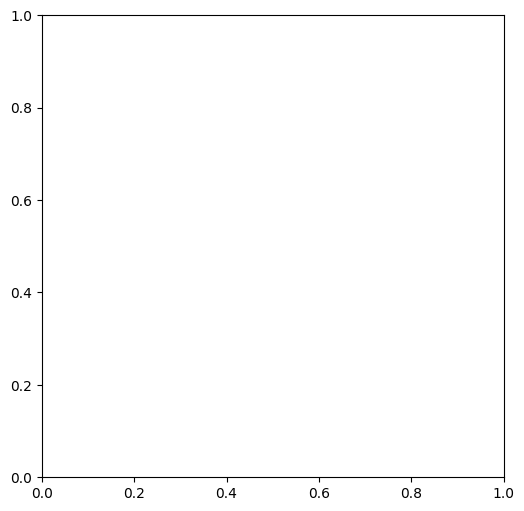

In [30]:
plt.close()
classes = ["Accepted", "Not Accepted"]
title = "Number of projects that are Accepted and not accepted"
# pie_chart(raw_df, classes, title)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = classes
y_value_counts = raw_df['project_is_approved'].value_counts()
data = [y_value_counts[1], y_value_counts[0]]

accepted_per = round(y_value_counts[1]/(y_value_counts[1] + y_value_counts[0])*100, 2)
not_accepted_per = round(y_value_counts[0]/(y_value_counts[1] + y_value_counts[0])*100, 2)

labels= ["Accepted ({0}%)".format(str(accepted_per)), "Not accepted ({0}%)".format(str(not_accepted_per))]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40, labels=labels)
plt.show()

## 2.4 Numerical features overview

Train dataset

In [ ]:
num_overview = numerical_overview(final_df.loc[:,final_df.columns[1]:], [])
num_overview.head(num_overview.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_21268\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_21268\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_21268\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_21268\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_

,Variable name,+ve value count,-ve value count,Zero count,Unique count,+ve infinity count,-ve infinity count,missing %,Count of outliers
0,IE Generation,35064,0,0,32485,0,0,0.000000,224
1,IE Demand,35064,0,0,32429,0,0,0.000000,6
2,IE Wind Availability,35064,0,0,32963,0,0,0.000000,0
3,IE Wind Generation,35046,0,18,32738,0,0,0.000000,0
4,SNSP,35064,0,0,6997,0,0,0.000000,0
5,Hydro Run-of-River,25795,0,5094,2033,0,0,11.906799,0
6,Fossil hard coal,23370,0,7519,3571,0,0,11.906799,1564
7,Fossil oil,27317,0,3572,5236,0,0,11.906799,0
8,Fossil peat,29723,0,1166,2970,0,0,11.906799,0
9,Fossil gas,30889,0,0,13166,0,0,11.906799,0


In [31]:
final_df.shape

(35064, 25)

### 2.4.1 Statistical overview

Train dataset

In [ ]:
num_stat_overview = stat_overview(final_df.loc[:, final_df.columns[1]:], [])
num_stat_overview.head(num_stat_overview.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_20668\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20668\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20668\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20668\106555088.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_

,Variable name,Count,Mean,Standard deviation,Variance,Min,25th Percentile,50th Percentile,75th Percentile,Max,10th Percentile,90th Percentile,95th Percentile
0,IE Generation,35064,3415.564472,657.505803,4.323139e+05,1518.2300,2941.4425,3354.5250,3840.2125,5981.5100,2617.43900,4317.326,4587.6670
1,IE Demand,35064,3453.132965,624.408974,3.898866e+05,2030.9200,2932.5175,3501.4250,3919.7650,5494.0400,2604.69800,4241.072,4447.7685
2,IE Wind Availability,35064,1298.652172,1019.016300,1.038394e+06,4.7900,407.7450,1041.9750,2046.4525,3969.2900,161.91900,2889.577,3249.6290
3,IE Wind Generation,35064,1168.694217,858.679060,7.373297e+05,0.0000,394.6775,1015.0850,1856.7675,3582.4600,146.92000,2418.830,2696.2205
4,SNSP,35064,0.359166,0.179201,3.211287e-02,0.0017,0.2187,0.3347,0.5141,0.7561,0.13183,0.619,0.6465
5,Hydro Run-of-River,30889,90.009252,64.567039,4.168903e+03,0.0000,27.5000,92.8000,151.3000,218.7000,0.00000,174.300,181.9000
6,Fossil hard coal,30889,196.403519,198.258136,3.930629e+04,0.0000,72.9000,117.8000,294.5000,761.5000,0.00000,502.400,628.9000
7,Fossil oil,30889,268.668808,193.965235,3.762251e+04,0.0000,83.2000,236.8000,438.8000,921.9000,0.00000,485.900,560.6000
8,Fossil peat,30889,141.176199,101.782556,1.035969e+04,0.0000,65.9000,105.8000,217.2000,347.0000,41.50000,326.020,336.8000
9,Fossil gas,30889,893.363916,407.497401,1.660541e+05,16.6000,552.5000,890.1000,1210.3000,1943.8000,385.98000,1454.120,1609.5600


## 2.7 Univariate Analysis

### A) Numeric variables

#### 2.7.1 Density plot with outliers

*   Train dataset



C:\Users\kagau\AppData\Local\Temp\ipykernel_20668\106555088.py:198: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20668\106555088.py:198: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local

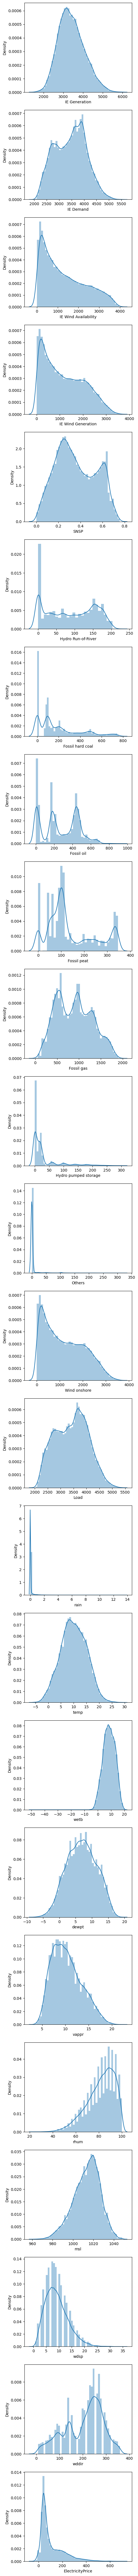

In [ ]:
plt.close()
density_plot(final_df.loc[:,final_df.columns[1]:],[])
plt.show()


#### 2.7.2 Density plot without outliers

*   Train dataset

C:\Users\kagau\AppData\Local\Temp\ipykernel_20668\106555088.py:198: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local\Temp\ipykernel_20668\106555088.py:198: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_df[col], ax=a)
C:\Users\kagau\AppData\Local

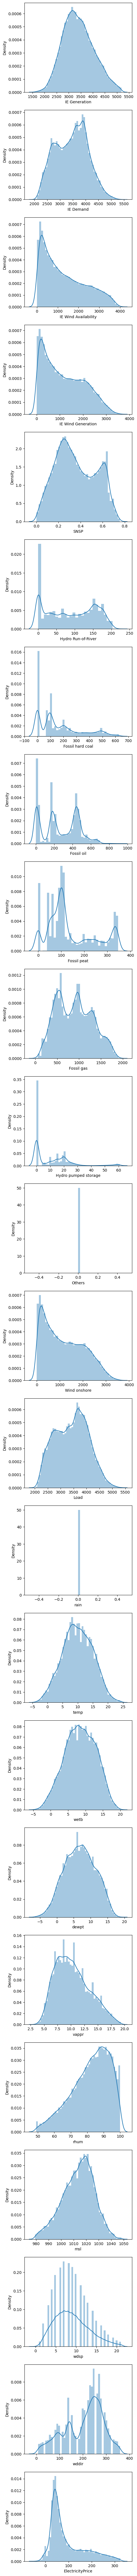

In [ ]:
plt.close()
density_plot(final_df.loc[:,final_df.columns[1]:],[], False)
plt.show()

#### 2.7.3 Box plot with Outliers

* Train dataset


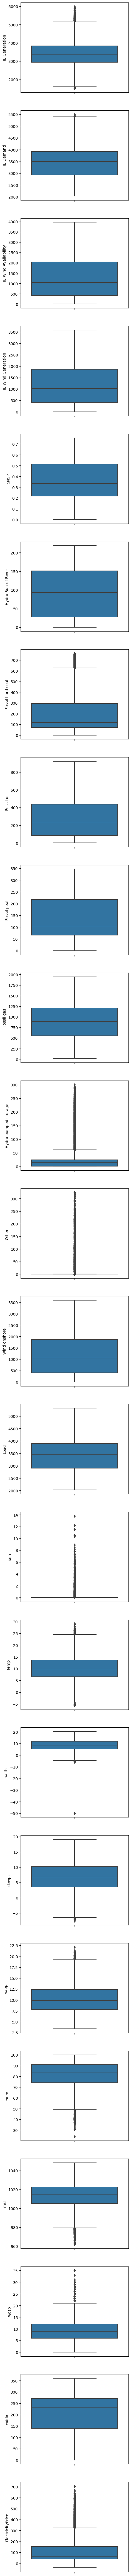

In [ ]:
plt.close()
box_plot(final_df.loc[:,final_df.columns[1]:], [])
plt.show()

#### 2.7.4 Box plot without outliers

* Train dataset

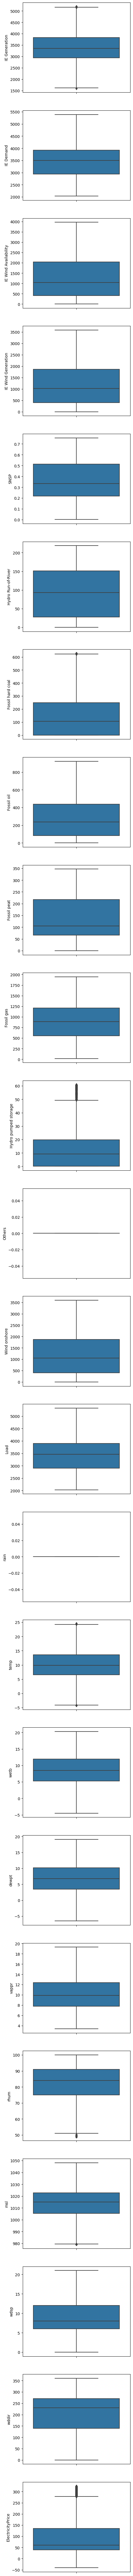

In [ ]:
plt.close()
box_plot(final_df.loc[:,final_df.columns[1]:], [], False)
plt.show()

##2.8 Bi-variate Analysis

###2.8.2 Correlation

In [ ]:
df = final_df.loc[:,final_df.columns[1]:]._get_numeric_data()
df.corr()

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,...,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ElectricityPrice
IE Generation,1.000000,0.811008,0.482538,0.545850,0.245527,0.473396,0.182207,-0.015309,0.133549,0.145931,...,0.048787,-0.107697,-0.141336,-0.178086,-0.171201,-0.138306,-0.180829,0.350792,0.004617,0.240124
IE Demand,0.811008,1.000000,0.133786,0.195822,0.028386,0.456383,0.316464,0.191847,0.168608,0.276675,...,0.008908,-0.041332,-0.099138,-0.164484,-0.154082,-0.243581,-0.063477,0.195595,0.003532,0.327948
IE Wind Availability,0.482538,0.133786,1.000000,0.979126,0.912439,0.265270,-0.220692,-0.516499,-0.058388,-0.522840,...,0.088341,-0.076828,-0.095628,-0.124965,-0.136606,-0.107958,-0.410257,0.655559,0.013282,-0.138501
IE Wind Generation,0.545850,0.195822,0.979126,1.000000,0.905528,0.289403,-0.205182,-0.508006,-0.026104,-0.496155,...,0.086591,-0.093443,-0.113155,-0.142604,-0.152883,-0.107208,-0.399142,0.641187,0.012797,-0.111495
SNSP,0.245527,0.028386,0.912439,0.905528,1.000000,0.222406,-0.292329,-0.551975,-0.036517,-0.622832,...,0.070376,-0.058289,-0.086215,-0.126893,-0.141610,-0.148781,-0.378207,0.627134,0.022748,-0.218638
Hydro Run-of-River,0.473396,0.456383,0.265270,0.289403,0.222406,1.000000,-0.028990,0.035722,0.359239,-0.009696,...,0.039046,-0.362906,-0.370330,-0.356361,-0.356800,0.041326,-0.205818,0.202966,0.083363,-0.019705
Fossil hard coal,0.182207,0.316464,-0.220692,-0.205182,-0.292329,-0.028990,1.000000,0.257956,-0.328924,0.031790,...,-0.023988,-0.044604,-0.029184,-0.005972,0.009094,0.083856,0.152197,-0.172252,0.005798,0.633883
Fossil oil,-0.015309,0.191847,-0.516499,-0.508006,-0.551975,0.035722,0.257956,1.000000,-0.025825,0.156077,...,-0.058894,0.042292,0.037532,0.036071,0.052366,-0.003796,0.231313,-0.336447,-0.036476,0.086867
Fossil peat,0.133549,0.168608,-0.058388,-0.026104,-0.036517,0.359239,-0.328924,-0.025825,1.000000,0.180888,...,0.002011,-0.311083,-0.315946,-0.298994,-0.317095,0.061423,-0.038103,-0.020982,0.052325,-0.266018
Fossil gas,0.145931,0.276675,-0.522840,-0.496155,-0.622832,-0.009696,0.031790,0.156077,0.180888,1.000000,...,-0.042670,0.016117,0.015723,0.019059,0.020762,0.010212,0.216102,-0.301979,-0.004550,0.132034


In [ ]:
df = final_df.loc[:,final_df.columns[1]:]._get_numeric_data()
df.corr(method='spearman')

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,...,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ElectricityPrice
IE Generation,1.000000,0.799670,0.487257,0.526407,0.256774,0.477684,0.147730,-0.062118,0.157689,0.133731,...,0.096694,-0.095470,-0.131834,-0.167790,-0.167855,-0.194902,-0.188222,0.360830,-0.027182,0.225066
IE Demand,0.799670,1.000000,0.123145,0.164715,0.032325,0.455926,0.290151,0.174877,0.191258,0.268789,...,0.023574,-0.044641,-0.098131,-0.158265,-0.158335,-0.272503,-0.062338,0.200593,-0.005533,0.392417
IE Wind Availability,0.487257,0.123145,1.000000,0.992720,0.911085,0.272274,-0.188199,-0.547476,-0.038776,-0.515537,...,0.171588,-0.094593,-0.117242,-0.134687,-0.134770,-0.145800,-0.411065,0.636705,-0.056162,-0.164109
IE Wind Generation,0.526407,0.164715,0.992720,1.000000,0.903489,0.288291,-0.175824,-0.537353,-0.021569,-0.495257,...,0.169152,-0.104262,-0.127665,-0.145512,-0.145595,-0.146719,-0.404402,0.630059,-0.056256,-0.137986
SNSP,0.256774,0.032325,0.911085,0.903489,1.000000,0.228298,-0.249556,-0.564876,-0.038104,-0.623650,...,0.138817,-0.069145,-0.101714,-0.132031,-0.132082,-0.190708,-0.383728,0.621885,-0.049404,-0.216701
Hydro Run-of-River,0.477684,0.455926,0.272274,0.288291,0.228298,1.000000,-0.040507,0.014803,0.345178,-0.010273,...,0.070686,-0.375922,-0.384385,-0.365139,-0.365124,0.000143,-0.199488,0.208047,0.049250,-0.018848
Fossil hard coal,0.147730,0.290151,-0.188199,-0.175824,-0.249556,-0.040507,1.000000,0.216669,-0.298768,0.006049,...,-0.027775,-0.031875,-0.018473,-0.000700,-0.000737,0.088810,0.109024,-0.147410,0.017808,0.651252
Fossil oil,-0.062118,0.174877,-0.547476,-0.537353,-0.564876,0.014803,0.216669,1.000000,0.007516,0.168662,...,-0.105358,0.030376,0.030583,0.026374,0.026307,0.028204,0.250171,-0.347751,0.003452,0.175537
Fossil peat,0.157689,0.191258,-0.038776,-0.021569,-0.038104,0.345178,-0.298768,0.007516,1.000000,0.183003,...,-0.013123,-0.317017,-0.327372,-0.315041,-0.314949,0.027042,-0.000662,-0.026985,0.048110,-0.179345
Fossil gas,0.133731,0.268789,-0.515537,-0.495257,-0.623650,-0.010273,0.006049,0.168662,0.183003,1.000000,...,-0.080294,0.026446,0.026323,0.025015,0.024955,0.026059,0.220671,-0.295802,0.037776,0.094228


In [32]:
final_df2=final_df.drop(columns=['Others', 'Wind onshore','Load'])
final_df2.shape

(35064, 22)

In [33]:
final_df2.to_excel("inputdata.xlsx")  

In [ ]:
g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

Error in callback <function flush_figures at 0x0000014693A3C540> (for post_execute):


KeyboardInterrupt: 

Text(0, 0.5, 'ElectricityPrice')

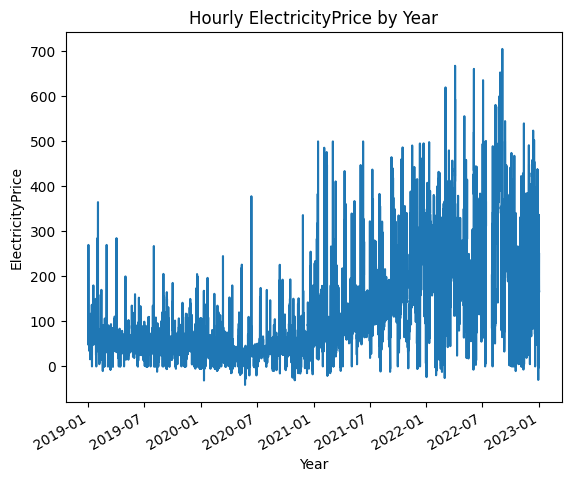

In [ ]:
plt.plot(final_df.TimeStamp, final_df.ElectricityPrice)
plt.title('Hourly ElectricityPrice by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('ElectricityPrice')

In [ ]:
means = final_df.groupby(pd.Grouper(key='TimeStamp', freq='D'))['ElectricityPrice_L'].mean()
means.head()

TimeStamp
2019-01-01    97.002917
2019-01-02    66.610000
2019-01-03    59.060000
2019-01-04    56.386667
2019-01-05    54.106250
Freq: D, Name: ElectricityPrice_L, dtype: float64

Text(0, 0.5, 'ElectricityPrice')

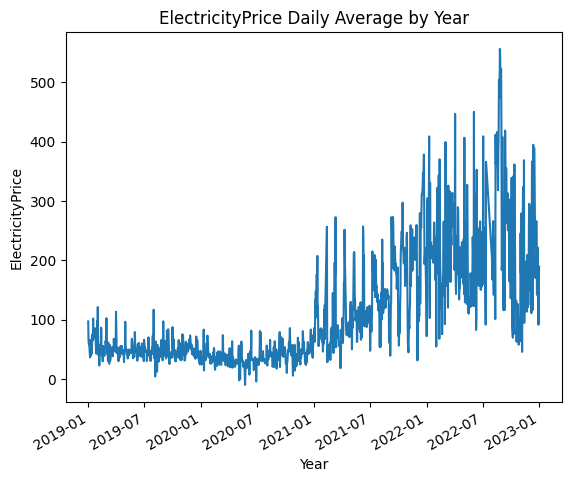

In [ ]:
plt.plot(means)
plt.title('ElectricityPrice Daily Average by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('ElectricityPrice')

In [ ]:
monthlymean= final_df.groupby(pd.Grouper(key='TimeStamp', freq='M'))['ElectricityPrice'].mean()
monthlymean.head()

TimeStamp
2019-01-31    64.867715
2019-02-28    53.297336
2019-03-31    49.427052
2019-04-30    49.382319
2019-05-31    48.396035
Freq: M, Name: ElectricityPrice, dtype: float64

Text(0, 0.5, 'ElectricityPrice')

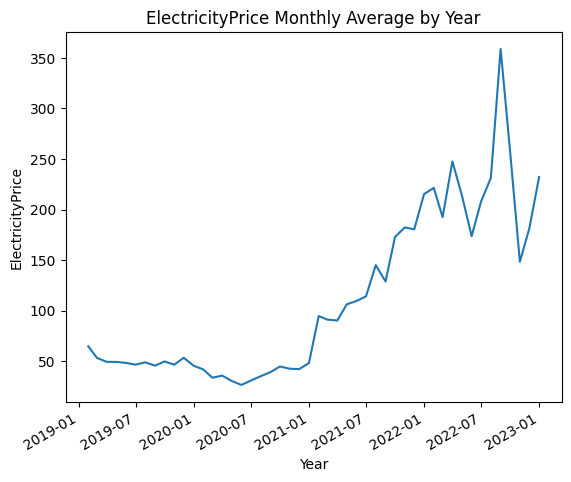

In [ ]:
plt.plot(monthlymean)
plt.title('ElectricityPrice Monthly Average by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('ElectricityPrice')

In [ ]:
qtrmean= final_df.groupby(pd.Grouper(key='TimeStamp', freq='Q'))['ElectricityPrice'].mean()
qtrmean.head()

TimeStamp
2019-03-31    55.952612
2019-06-30    48.144574
2019-09-30    48.142473
2019-12-31    48.569524
2020-03-31    37.215602
Freq: Q-DEC, Name: ElectricityPrice, dtype: float64

Text(0, 0.5, 'ElectricityPrice')

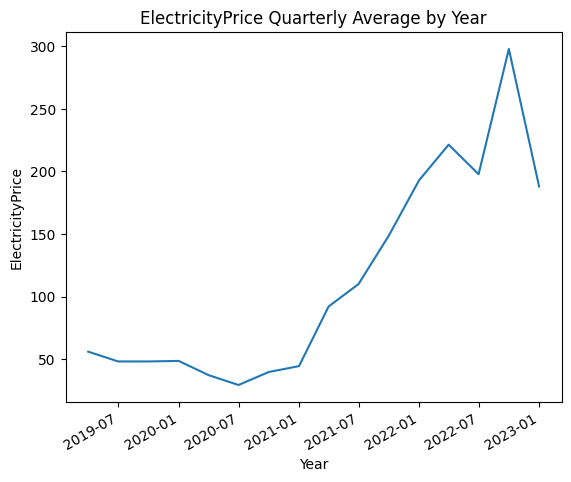

In [ ]:
plt.plot(qtrmean)
plt.title('ElectricityPrice Quarterly Average by Year')
plt.xticks(rotation=30, ha='right')
plt.xlabel('Year')
plt.ylabel('ElectricityPrice')

In [ ]:
dailydf = means.to_frame().reset_index()
dailydf.head()


,TimeStamp,ElectricityPrice_L
0,2019-01-01,97.002917
1,2019-01-02,66.610000
2,2019-01-03,59.060000
3,2019-01-04,56.386667
4,2019-01-05,54.106250


In [ ]:
final_df['ElectricityPrice_L']= final_df['ElectricityPrice'].interpolate(method='linear')

In [ ]:
dailymeans = final_df.groupby(pd.Grouper(key='TimeStamp', freq='D'))['ElectricityPrice_L'].mean()
dailymeans.head()

TimeStamp
2019-01-01    97.002917
2019-01-02    66.610000
2019-01-03    59.060000
2019-01-04    56.386667
2019-01-05    54.106250
Freq: D, Name: ElectricityPrice_L, dtype: float64

In [ ]:
# setting the plot size
plt.rcParams['figure.figsize']=(15,7)
# on our data, impute the missing values using rolling window method
dailydf['ElectricityPrice_L']= dailydf['ElectricityPrice'].interpolate(method='linear')
# plot the complete dataset
plt.plot(dailydf['ElectricityPrice_L'], color='blue')
# add the tittle of our plot as Linear interpolation
plt.title('Linear interpolation')
# print the plot
plt.show()

KeyError: 'ElectricityPrice'

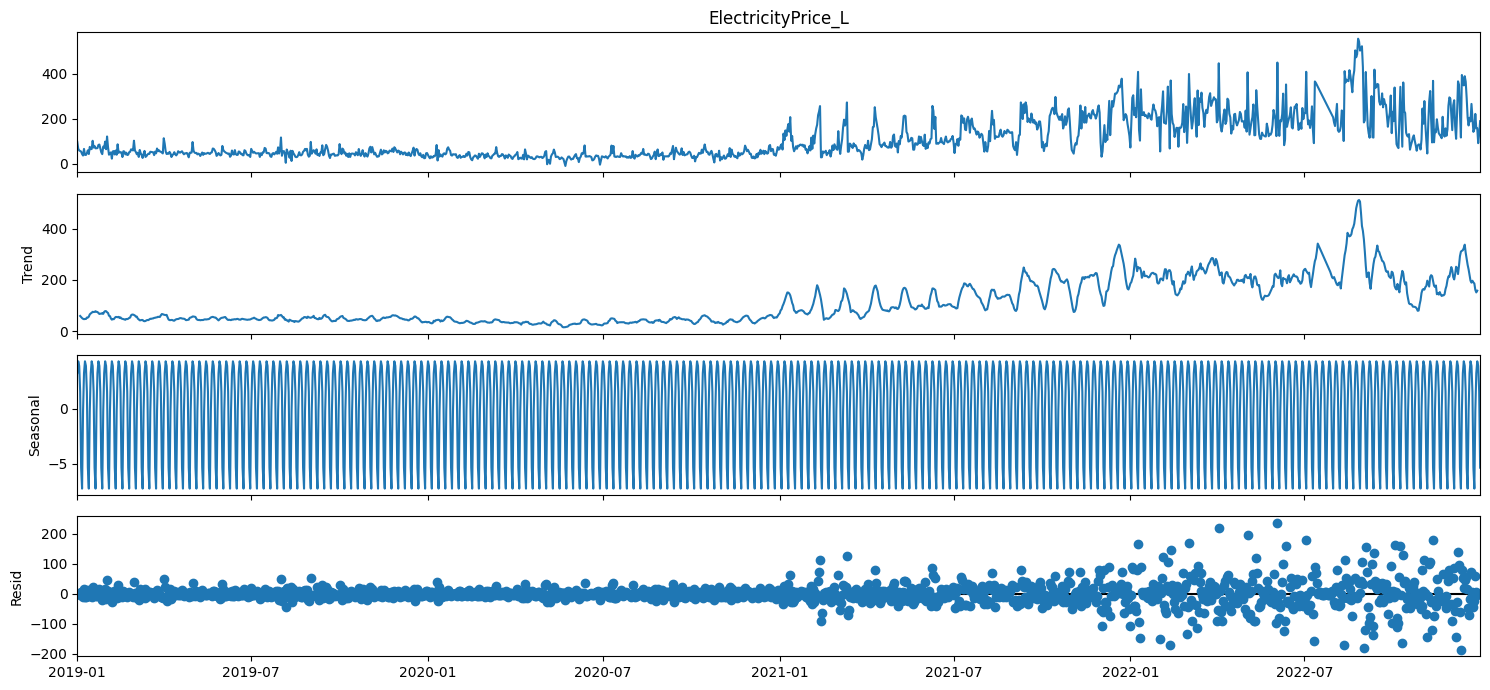

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(dailymeans, model="addictive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

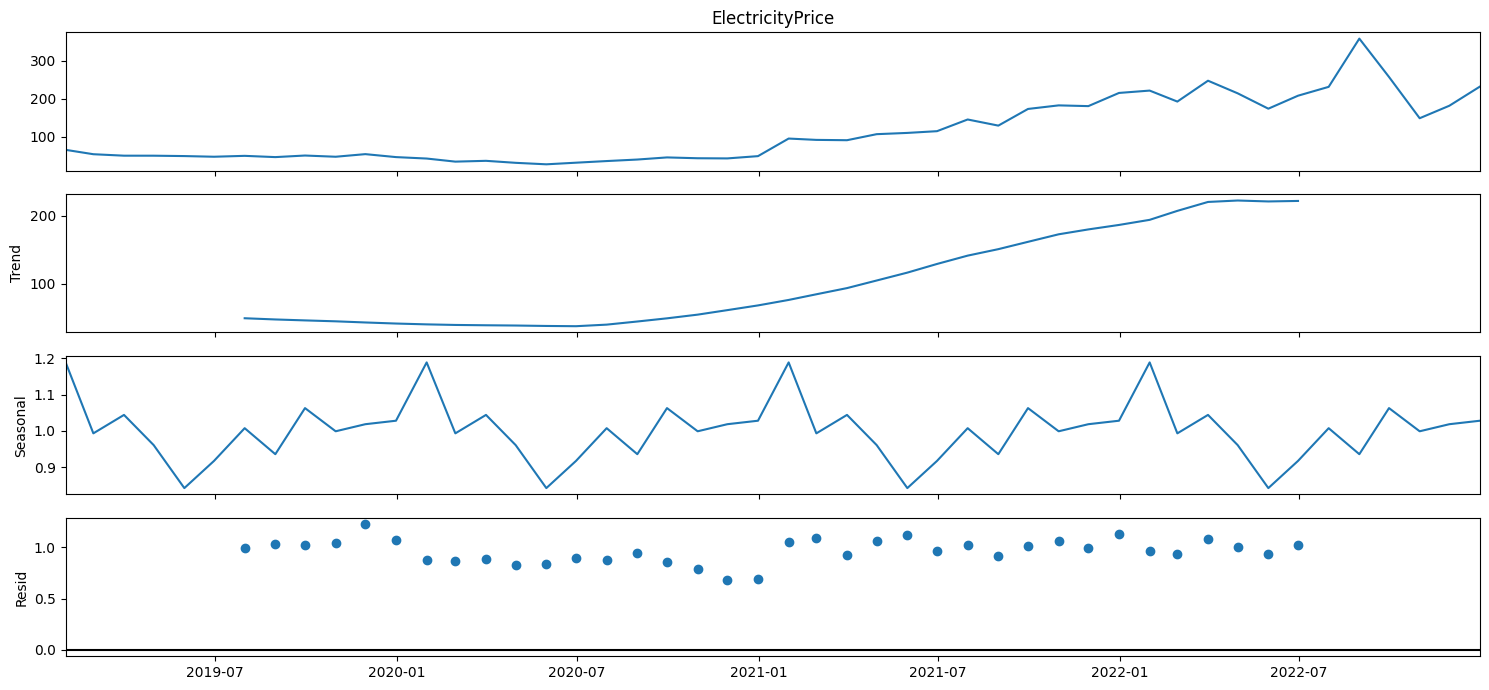

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(monthlymean, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

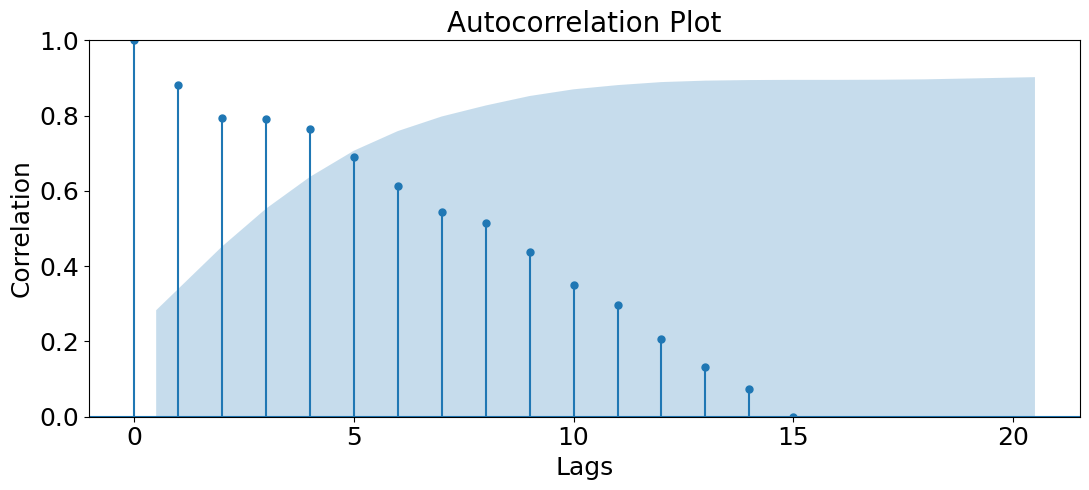

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf


# Plot autocorrelation
plt.rc("figure", figsize=(11,5))
plot_acf(monthlymean, lags=20)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

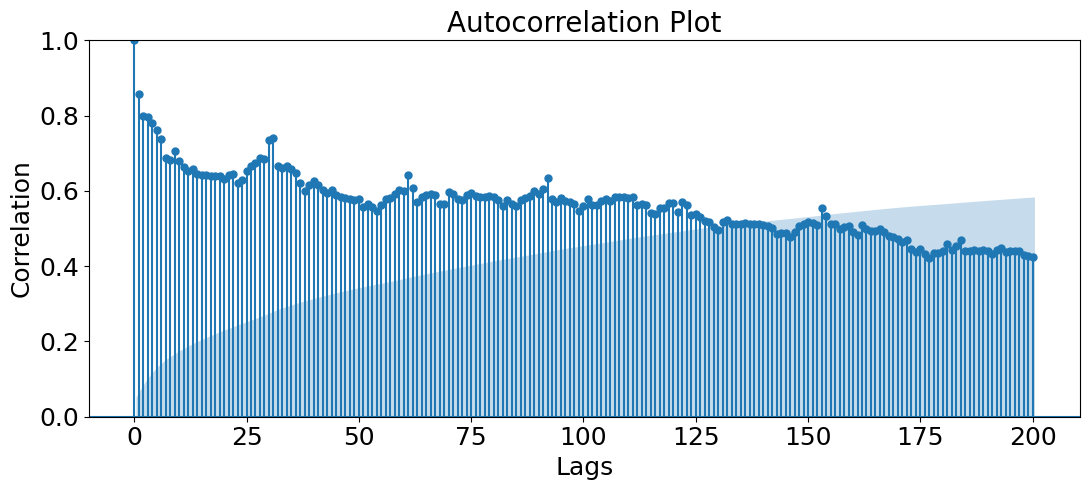

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf


# Plot autocorrelation
plt.rc("figure", figsize=(11,5))
plot_acf(dailymeans, lags=200)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

In [ ]:
newdf = monthlymean.to_frame().reset_index()
newdf.head()

,TimeStamp,ElectricityPrice
0,2019-01-31,64.867715
1,2019-02-28,53.297336
2,2019-03-31,49.427052
3,2019-04-30,49.382319
4,2019-05-31,48.396035


In [ ]:
newdf['TimeStamp'] = pd.to_datetime(newdf['TimeStamp'])
newdf['year'] = newdf['TimeStamp'].dt.year
newdf['day'] = newdf['TimeStamp'].dt.day
newdf['month'] = newdf['TimeStamp'].dt.month_name().str[:3]
#newdf = newdf.pivot_table(index='year', columns='month', values='ElectricityPrice', aggfunc='sum')
newdf.head()

,TimeStamp,ElectricityPrice,year,day,month
0,2019-01-31,64.867715,2019,31,Jan
1,2019-02-28,53.297336,2019,28,Feb
2,2019-03-31,49.427052,2019,31,Mar
3,2019-04-30,49.382319,2019,30,Apr
4,2019-05-31,48.396035,2019,31,May


In [ ]:
fig = px.line_polar( newdf,r="ElectricityPrice", theta="month", color="year", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)
fig.show()

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append me

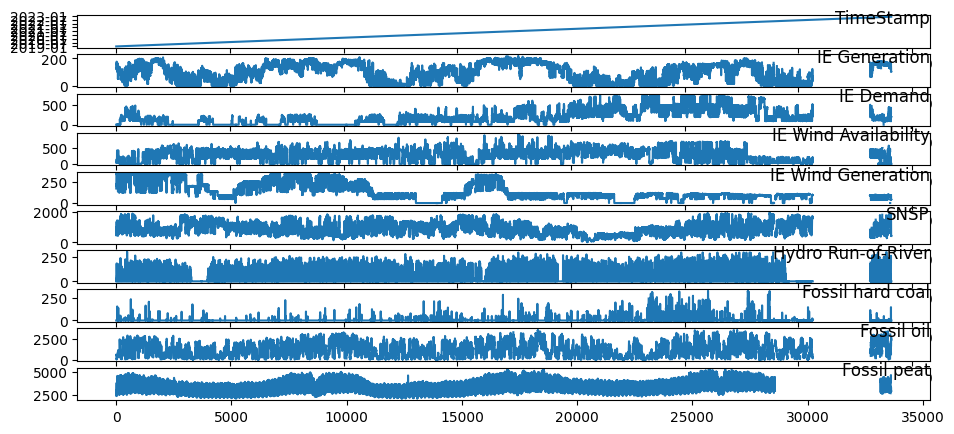

In [ ]:
values = energyData.values
# specify columns to plot
groups = range(0,10)
i = 1
# plot each column
plt.figure()
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(final_df.columns[group], y=0.5, loc='right')
 i += 1
plt.rc("figure", figsize=(50,30))
plt.show()

In [ ]:
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
modeldata = final_df[['TimeStamp', 'ElectricityPrice_L']]
modeldata.head()

,TimeStamp,ElectricityPrice_L
0,2019-01-01 00:00:00,70.28
1,2019-01-01 01:00:00,65.18
2,2019-01-01 02:00:00,60.91
3,2019-01-01 03:00:00,65.16
4,2019-01-01 04:00:00,65.16


In [ ]:
modeldata = modeldata.set_index('TimeStamp',inplace=True)
modeldata.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
from statsmodels.graphics.tsaplots  import plot_acf,plot_pacf

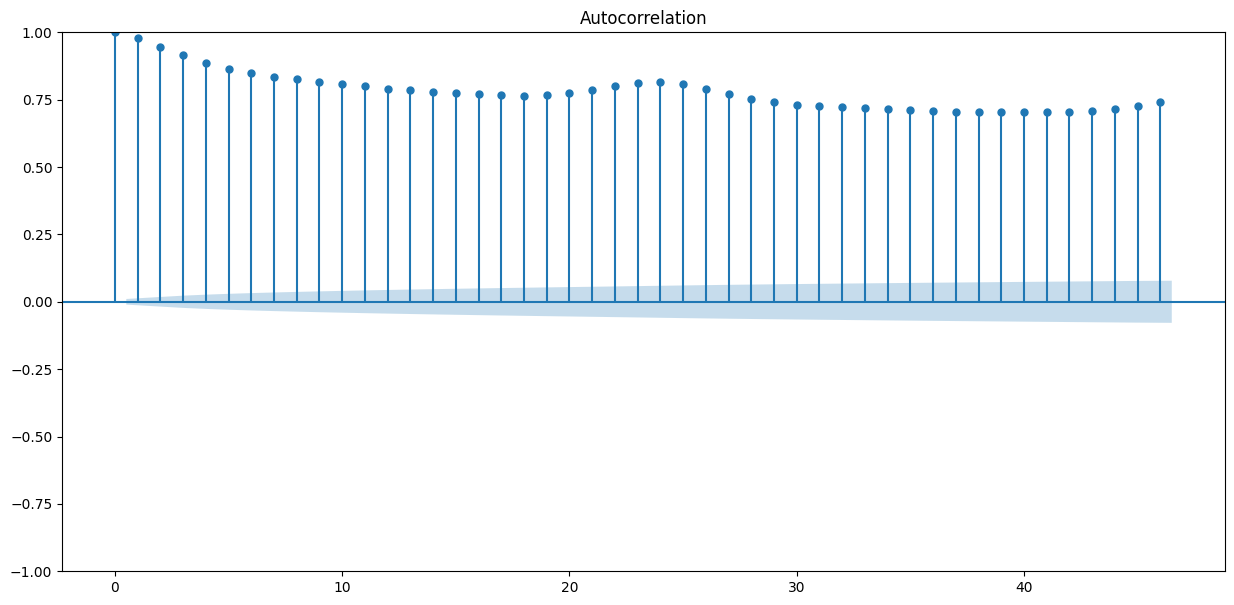

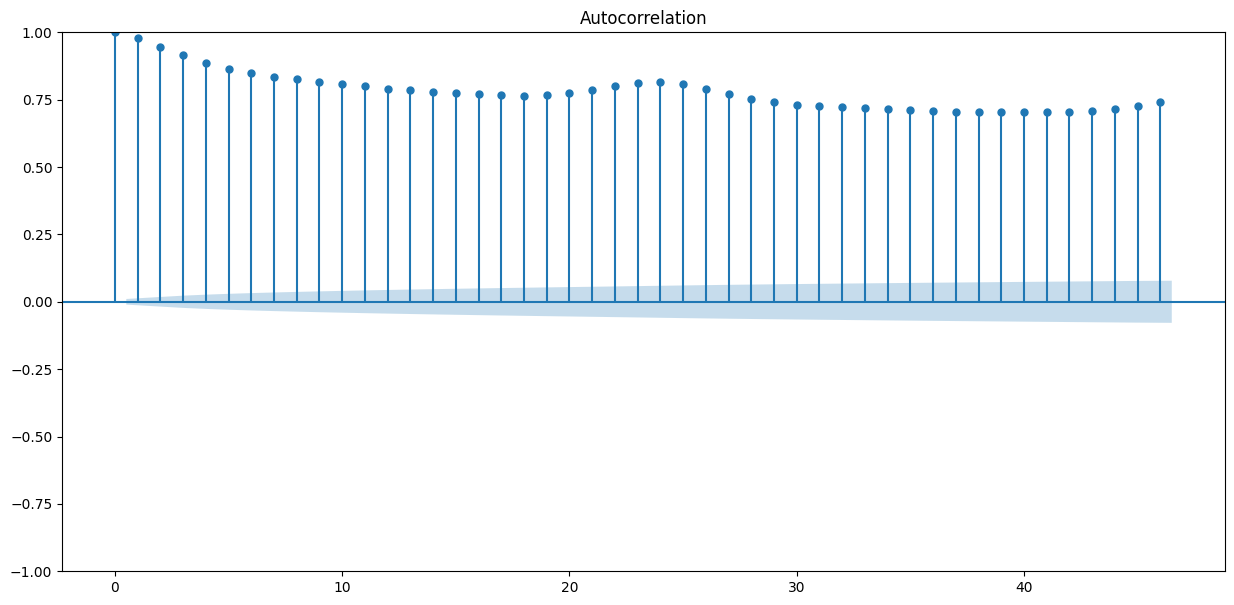

In [ ]:
plot_acf(modeldata['ElectricityPrice_L'])

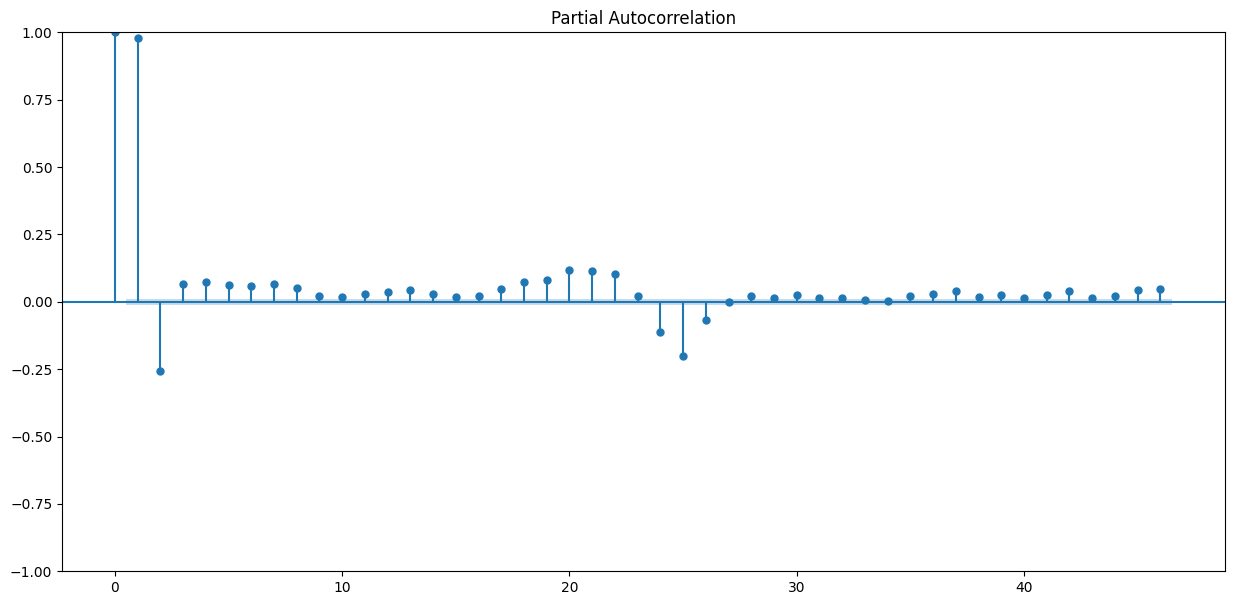

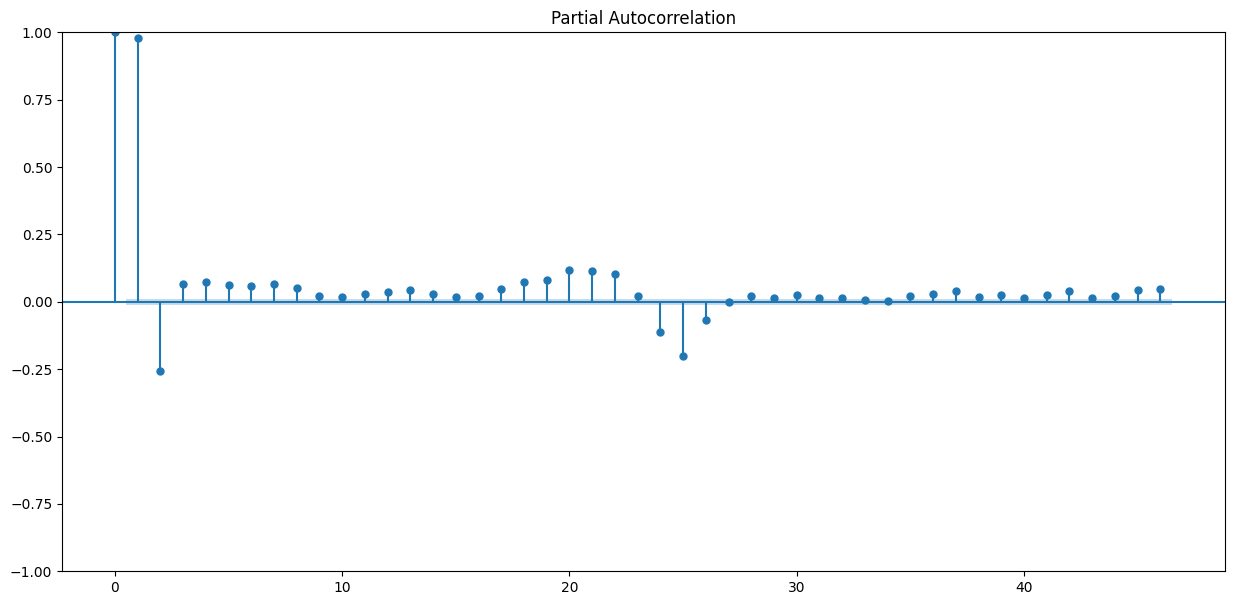

In [ ]:
plot_pacf(modeldata['ElectricityPrice_L'])

In [ ]:
from scipy import fft
from scipy import signal as sig
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import model_selection

In [ ]:
result = adfuller(final_df['ElectricityPrice_L'])

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

ADF Statistic: -7.811768
p-value: 0.000000


In [ ]:

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(modeldata['ElectricityPrice_L'].diff().diff().dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -52.470855
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    35009.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


In [ ]:
# Load the data and split it into separate pieces

train, test = model_selection.train_test_split(dailymeans)
xtrain = train.drop(columns=["ElectricityPrice"])


In [ ]:
xtest = test.drop(columns=["ElectricityPrice"])

In [ ]:
model=pm.auto_arima(xtrain,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=11030.377, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=10643.767, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=10952.978, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=10508.266, Time=0.82 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=10414.010, Time=1.73 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=10346.823, Time=3.06 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=10319.961, Time=13.00 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=122.99 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=10.93 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=10416.019, Time=10.02 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=10299.626, Time=15.04 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=10323.708, Time=4.31 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=140.89 sec
 ARIMA(2,1,0)(4,1,1)[

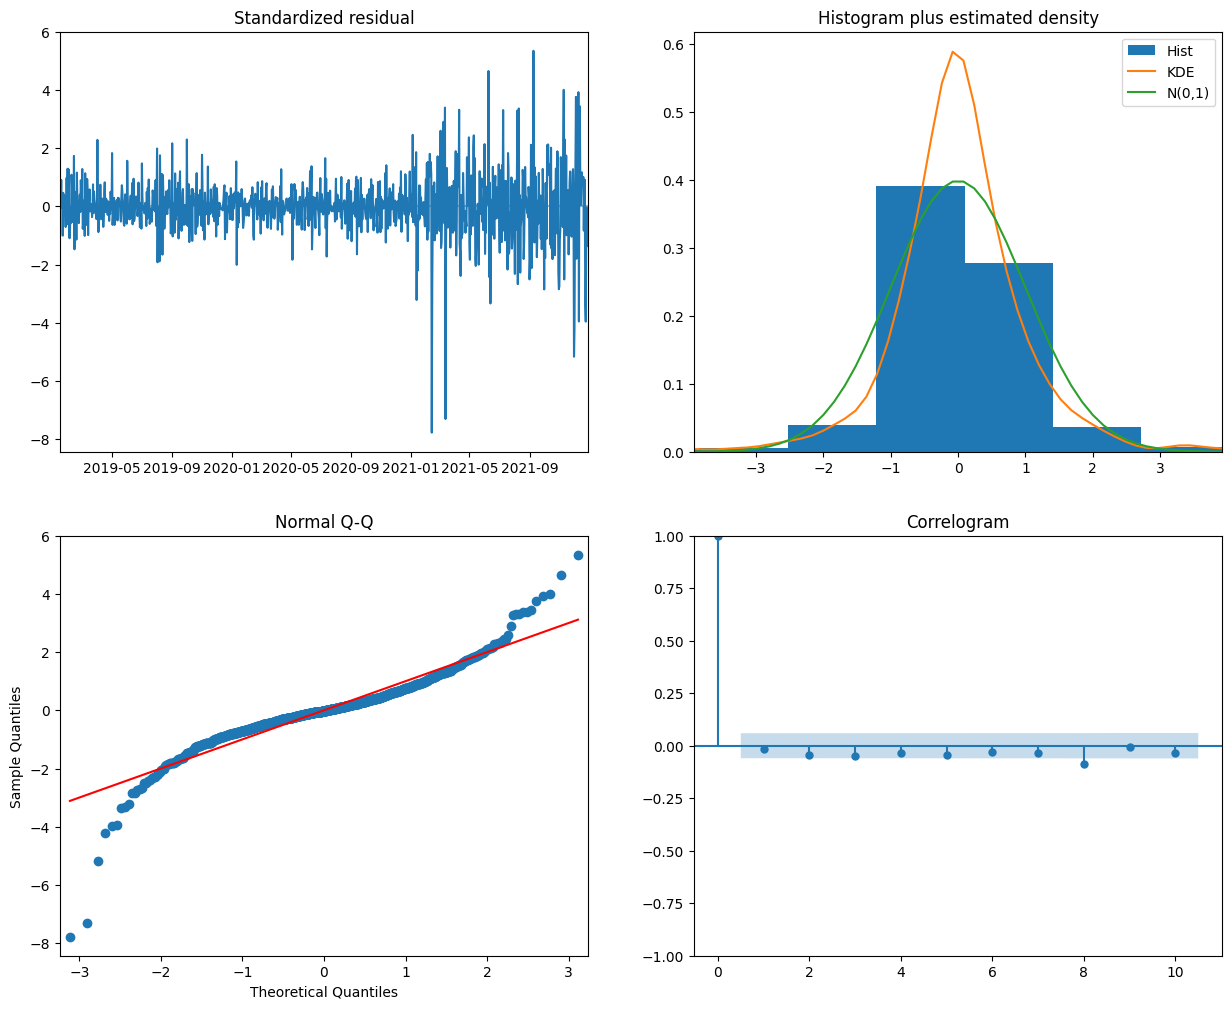

In [ ]:
model.plot_diagnostics(figsize=(15,12))
plt.show()


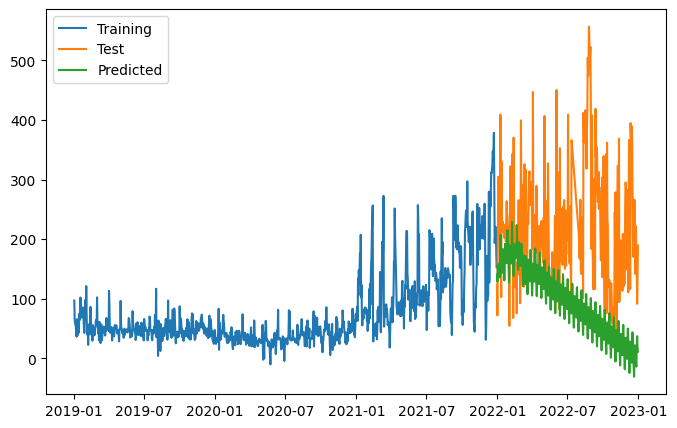

In [ ]:
prediction = pd.DataFrame(model.predict(n_periods = 600),index=xtest.index)
prediction.columns = ['ElectricityPrice_L']
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('SecondPrection.jpg')
plt.show()

In [ ]:
print(model.summary)

<bound method ARIMA.summary of ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(5, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)>


In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(dailymeans.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(dailymeans.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(dailymeans, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)

NameError: name 'SARIMAX_model' is not defined

##2.9 Missing values

We can see that the data for project_essay_3 and project_essay_4 is limited upto the date **" May 17, 2016"**. The work around for this problem is to merge the rows with the data for project_essay_1 & project_essay_2 as "project_essay_1" then project_essay_3 & project_essay_4 as "project_essay_2", as followed after May 17, 2016.

In [ ]:
df = train_resource_df[train_resource_df["project_essay_3"].isnull() == False]
df["project_essay_1"] = df["project_essay_1"].values + "," + df["project_essay_2"]
df["project_essay_2"] = df["project_essay_3"].values + "," + df["project_essay_4"]

train_resource_df = train_resource_df.drop(columns=["project_essay_3","project_essay_4"])
train_resource_df.append(df)
train_resource_df.head()

In [ ]:
print(train_resource_df["teacher_prefix"].isnull().sum())

#3) Feature Engineering

##3.1 Pre-processing

###3.1.1 Categorical data

####a) Teacher_prefix

In [ ]:
train_resource_df["teacher_prefix"] = train_resource_df["teacher_prefix"].transform(lambda x : str(x[:-1]).lower() if x[-1] == "." else str(x).lower())
train_resource_df["teacher_prefix"].value_counts()

####b) School_state

In [ ]:
train_resource_df["school_state"] = train_resource_df["school_state"].str.lower()
train_resource_df["school_state"].value_counts()

####c) Project_grade_category

In [ ]:
train_resource_df["project_grade_category"].value_counts()

In [ ]:
train_resource_df["project_grade_category"] = train_resource_df["project_grade_category"].transform(lambda x : re.sub("[^A-Za-z0-9]+", "_", str(x)))
train_resource_df["project_grade_category"] = train_resource_df["project_grade_category"].str.lower()
train_resource_df["project_grade_category"].value_counts()

####d) Project_subject_categories

In [ ]:
train_resource_df["project_subject_categories"].value_counts()

In [ ]:
train_resource_df["project_subject_categories"] = train_resource_df["project_subject_categories"].transform(lambda x : re.sub("[^A-Za-z0-9]+", "_", str(x)))
train_resource_df["project_subject_categories"] = train_resource_df["project_subject_categories"].str.replace("The","")
train_resource_df["project_subject_categories"] = train_resource_df["project_subject_categories"].str.lower()
train_resource_df["project_subject_categories"].value_counts()

In [ ]:
dummy = train_resource_df.copy()

####e) Project_subject_subcategories

In [ ]:
dummy["project_subject_subcategories"].value_counts()

In [ ]:
train_resource_df["project_subject_subcategories"] = train_resource_df["project_subject_subcategories"].transform(lambda x : re.sub("[^A-Za-z0-9]+", "_", str(x)))
train_resource_df["project_subject_subcategories"] = train_resource_df["project_subject_subcategories"].str.replace("The","")
train_resource_df["project_subject_subcategories"] = train_resource_df["project_subject_subcategories"].str.lower()
train_resource_df["project_subject_subcategories"].value_counts()

###3.1.2 Text data

####a) Project title

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [ ]:
train_resource_df["project_title"] = preprocess_text(train_resource_df["project_title"])
train_resource_df["project_title"].head()

####b) Essay

In [ ]:
train_resource_df["essay"] = train_resource_df["project_essay_1"].map(str) +\
                        train_resource_df["project_essay_2"].map(str)

train_resource_df["essay"] = preprocess_text(train_resource_df["essay"])
train_resource_df["essay"].head()

In [ ]:
train_resource_df.drop(columns=["project_essay_1", "project_essay_2"])

####c) Description

In [ ]:
train_resource_df["desc"] = preprocess_text(train_resource_df["desc"])
train_resource_df.head()

##3.2 Vectorization

###3.2.1 Splitting data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Y = train_resource_df["project_is_approved"]
X = train_resource_df.drop(columns=["project_is_approved"])

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.33, stratify=Y)



###3.2.2 Numerical data

####a) Price

In [ ]:
X_train["price_total"].shape
a = X_train["price_total"].values.reshape(6700,1)
a.shape

In [ ]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer(norm='l1')
normalizer.fit(X_train["price_total"].values.reshape(X_train["price_total"].shape[0],1))
price_norm_train = normalizer.transform(X_train["price_total"].values.reshape(-1,1))
price_norm_test = normalizer.transform(X_test["price_total"].values.reshape(-1,1))
print("Shape of matrix after normalizing ",price_norm_train.shape)
print("Shape of matrix after normalizing ",price_norm_test.shape)

####b) Quantity

In [ ]:
normalizer = Normalizer(norm='l1')

normalizer.fit(X_train["quantity_total"].values.reshape(1,X_train["quantity_total"].shape[0]))
quantity_norm_train = normalizer.transform(X_train["quantity_total"].values.reshape(-1,1))
quantity_norm_test = normalizer.transform(X_test["quantity_total"].values.reshape(-1,1))
print("Shape of matrix after normalizing ",quantity_norm_train.shape)
print("Shape of matrix after normalizing ",quantity_norm_train.shape)

####c) Teacher_number_of_previously_posted_projects

In [ ]:
normalizer = Normalizer(norm='l1')

row = X_train["teacher_number_of_previously_posted_projects"].shape[0]
normalizer.fit(X_train["teacher_number_of_previously_posted_projects"].values.reshape(1,row))
prev_proj_norm_train = normalizer.transform(X_train["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))
prev_proj_norm_test = normalizer.transform(X_test["teacher_number_of_previously_posted_projects"].values.reshape(-1,1))
print("Shape of matrix after normalizing ",prev_proj_norm_train.shape)
print("Shape of matrix after normalizing ",prev_proj_norm_train.shape)

####d) Average W2V

In [ ]:
import pickle

with open('/content/gdrive/My Drive/Colab Notebooks/Datasets/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

avg_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(train_resource_df["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(avg_w2v_vectors[:5])

####e) Tf-idf W2V

In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train_resource_df["essay"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(train_resource_df["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(tfidf_w2v_vectors[:5])
print(len(tfidf_w2v_vectors[0]))

##3.3 Combining vectorized data

In [ ]:
from scipy.sparse import hstack

X_tr = hstack((price_norm_train, teacher_prefix_train_ohe, school_state_train_ohe, \
               project_grade_cat_train_ohe, project_subj_cat_train_ohe, project_subj_subcat_train_ohe, essay_bow_train, \
               prev_proj_norm_train)).tocsr()
X_te = hstack((price_norm_test, teacher_prefix_test_ohe, school_state_test_ohe, \
               project_grade_cat_test_ohe, project_subj_cat_test_ohe, project_subj_subcat_test_ohe, essay_bow_test, \
               prev_proj_norm_test)).tocsr()

##quantity_norm_train, prev_proj_norm_train, , tf_idf_desc_train

In [ ]:
X_tr.shape

#4) Modelling

##4.1 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

k_val = sorted(random.sample(range(1,100),10))
k_val.append(101)

train_scores = []
cv_scores = []
for k in tqdm(k_val):
  clf = KNeighborsClassifier(k, n_jobs=-1)
  clf.fit(X_tr, Y_train)

  scores = cross_validate(clf, X_tr, Y_train, cv=5, scoring=('roc_auc'), return_train_score=True)
  print(scores.keys())
  train_scores.append(scores["train_score"])
  cv_scores.append(scores["test_score"])

In [ ]:
print(train_scores)

In [ ]:
train_auc = []
cv_auc = []
for i in range(len(train_scores)):
  avg = (train_scores[i].sum())/len(train_scores[i])
  train_auc.append(avg)
  avg = (cv_scores[i].sum())/len(cv_scores[i])
  cv_auc.append(avg)

In [ ]:
print(cv_auc)

In [ ]:
plt.plot(k_val, train_auc, label='Train AUC')
plt.plot(k_val, cv_auc, label='CV AUC')

plt.scatter(k_val, train_auc, label='Train AUC points')
plt.scatter(k_val, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

##4.2 Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

alpha_val = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]

train_auc = []
cv_auc = []
# for alpha in tqdm(alpha_val):
clf = MultinomialNB()

train_scores = []
cv_scores = []

# space['alpha'] = loguniform(1e-5, 100)
distribution =  {'alpha' : alpha_val}
#'class_prior': [[uniform.rvs(0,1), uniform.rvs(0,1)]], \

Multi_NB = RandomizedSearchCV(clf, distribution, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
# clf.fit()
Multi_NB.fit(X_tr, Y_train)

train_auc.extend(Multi_NB.cv_results_["mean_train_score"])
cv_auc.extend(Multi_NB.cv_results_["mean_test_score"])
  # print(Multi_NB.cv_results_["mean_test_score"])
  # print("*"*50)

  # scores = cross_validate(clf, X_tr, Y_train, cv=5, scoring=('roc_auc'), return_train_score=True)
  # print(scores.keys())
  # train_scores.append(scores["train_score"])
  # cv_scores.append(scores["test_score"])

In [ ]:
print(Multi_NB.cv_results_)

In [ ]:
a = Multi_NB.cv_results_["params"]
alphai = []
for i in a:
  alphai.append(i["alpha"])
  print(i["alpha"])

In [ ]:

for i in range(len(train_scores)):
  avg = (train_scores[i].sum())/len(train_scores[i])
  train_auc.append(avg)
  avg = (cv_scores[i].sum())/len(cv_scores[i])
  cv_auc.append(avg)

In [ ]:
import math
# alphai = [math.log10(i) for i in alphai]
# print(a)
alphai = sorted(alphai)
print(alphai)


plt.figure(figsize=(20,10))
plt.plot(alphai, train_auc, label='Train AUC')
plt.plot(alphai, cv_auc, label='CV AUC')

plt.scatter(alphai, train_auc, label='Train AUC points')
plt.scatter(alphai, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log-Alpha: hyperparameter")
plt.ylabel("AUC")
# plt.xticks(ticks=alphai)
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
#math. -2.3010299956639813

In [ ]:
from sklearn.metrics import roc_curve, auc
clf = MultinomialNB(alpha=0.01, class_prior=[0.8968623436647256, 0.758342717535217])
clf.fit(X_tr, Y_train)

score_train = clf.predict_proba(X_tr)
score_test = clf.predict_proba(X_te)
# (X_tr,Y_train)

fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, score_train[:, 1])
fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, score_test[:, 1])

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='ROC curve train data')
plt.plot(fpr_test, tpr_test, color='navy', lw=lw, label='ROC curve test data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

score_train = clf.predict(X_tr)
score_test = clf.predict(X_te)
conf_matrix = confusion_matrix(Y_train, score_train)

sns.heatmap(conf_matrix,annot=True,fmt="d",cmap='Blues')

In [ ]:
log_proba = clf.feature_log_prob_
neg_proba = log_proba[0].argsort()
pos_proba = log_proba[1].argsort()

In [ ]:
top_features_neg = []
for i in range(len(neg_proba)-1, len(neg_proba)-501, -1):
  top_features_neg.append(neg_proba[i])

print(top_features_neg)

In [ ]:
top_features_pos = []
for i in range(len(pos_proba)-1, len(pos_proba)-501, -1):
  top_features_pos.append(pos_proba[i])

print(top_features_pos[:20])

In [ ]:
print(len(top_features))

price_norm_train, teacher_prefix_train_ohe, school_state_train_ohe, \
               project_grade_cat_train_ohe, project_subj_cat_train_ohe, project_subj_subcat_train_ohe, essay_bow_train, \
               quantity_norm_train, prev_proj_norm_train, tf_idf_desc_train

In [ ]:
# feature_lst = []
# feature_lst.append("price_total")




In [ ]:
train_resource_df.head()

In [ ]:
feature_lst.append("teacher_number_of_previously_posted_projects")

In [ ]:
import scipy
top_features_neg.extend(top_features_pos)
# print(len(top_features_neg))
# a = scipy.sparse.csr.csr_matrix((6700,40))
# for i in range(len(top_features_neg)):
#   index = top_features_pos[i]
#   a[i] = X_tr[index].copy()

# index = top_features_pos[19]
# print(index)
# a[1]
print((X_tr).shape)

a = X_tr[:,top_features_neg]

In [ ]:
a.shape

In [ ]:
clf = MultinomialNB()

distribution =  {'class_prior': [[0.8968623436647256, 0.758342717535217]], \
                 'alpha' : loguniform(1e-5, 100)}

Multi_NB = RandomizedSearchCV(clf, distribution,cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True)
Multi_NB.fit(a, Y_train)
# clf.predict(X_tr)
# score_train = clf.score(X_tr, Y_train)
# score_test = clf.score(X_te, Y_test)
# print(score_train, score_test)

In [ ]:
scores = Multi_NB.cv_results_
print(scores["mean_train_score"])
print(scores["mean_test_score"])

In [ ]:
a.shape